# Analyze Forced Photometry in ComCam Data

In [1]:
# %pip install lsdb dask nested-dask 

In [2]:
import lsdb
lsdb.__version__

'0.5.0'

## Start Dask client

In [3]:
from dask.distributed import Client

# Start with a small client
client = Client(n_workers=1, memory_limit="16GB", threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:9561,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:33109,Total threads: 1
Dashboard: http://127.0.0.1:12295/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:28791,


# Load GAIA Data Around the COMCAM Field

In [4]:
source_lsdb_server = "https://data.lsdb.io/hats"  # "http://epyc.astro.washington.edu:43210/hats" #is the alternative server

In [5]:
gaia_columns = [
    "solution_id",
    "designation",
    "source_id",
    "random_index",
    "ref_epoch",
    "ra",
    "ra_error", 
    "dec",
    "dec_error",
    "ruwe",
    "phot_variable_flag",
    "phot_g_mean_flux_over_error",
    "phot_bp_mean_flux_over_error",
    "phot_rp_mean_flux_over_error",
]
gaia_columns

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'ruwe',
 'phot_variable_flag',
 'phot_g_mean_flux_over_error',
 'phot_bp_mean_flux_over_error',
 'phot_rp_mean_flux_over_error']

In [6]:
from upath import UPath
import hats
from lsdb.core.search import ConeSearch

catalogs_dir = UPath(source_lsdb_server)

# Gaia
gaia_path = catalogs_dir / "gaia_dr3" / "gaia"

# Define the six fields from Data Preview 1 with RA and Dec coordinates
fields = {
    "ECDFS": (53.13, -28.10),  # Extended Chandra Deep Field South
    "EDFS": (59.10, -48.73),  # Euclid Deep Field South
    "Rubin_SV_38_7": (37.86, 6.98),  # Low Ecliptic Latitude Field
    "Rubin_SV_95_-25": (95.00, -25.00),  # Low Galactic Latitude Field
    "47_Tuc": (6.02, -72.08),  # 47 Tuc Globular Cluster
    "Fornax_dSph": (40.00, -34.45)  # Fornax Dwarf Spheroidal Galaxy
}

# Define a 2-degree (2*3600 arcseconds) search radius
radius_arcsec = 2 * 3600  # Convert 2 degree to arcseconds
# Create six cone searches
cones = {name: ConeSearch(ra=ra, dec=dec, radius_arcsec=radius_arcsec) for name, (ra, dec) in fields.items()}

# Define a 0.7 degree cone region of interest
# This includes the so called `Fornax dSph` field, one of the ComCam fields from
# https://community.lsst.org/t/locations-of-target-fields-observed-during-on-sky-commissioning-campaign-with-comcam/9609
#cone_search = ConeSearch(ra=40, dec=-34.45, radius_arcsec=0.7 * 3600)


hats_gaia = hats.read_hats(gaia_path)

#gaia = lsdb.read_hats(gaia_path, columns=hats_gaia.schema.names, search_filter=cone_search) #filters=gaia_filters, )
gaia = lsdb.read_hats(gaia_path, columns=hats_gaia.schema.names, search_filter=cones["Fornax_dSph"]) #filters=gaia_filters, )

In [7]:
# Filter column phot_variable_flag=CONSTANT
"""
gaia_filters = [
    #["phot_variable_flag", "!=", "VARIABLE"],
    ["phot_g_mean_flux_over_error", ">", 20],
    ["phot_bp_mean_flux_over_error", ">", 20],
    ["phot_rp_mean_flux_over_error", ">", 20],
    #["ruwe", "<", 1.2],
]
"""
filtered_gaia = gaia.query("ruwe < 1.2").query("phot_variable_flag != 'VARIABLE'").query("phot_rp_mean_flux_over_error > 20")

In [8]:
filtered_gaia_compute = filtered_gaia.head(100)
filtered_gaia_compute

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,Norder,Dir,Npix
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2476932495248370962,1636148068921376768,Gaia DR3 4953864963388462720,4953864963388462720,161230471,2016.0,39.890592,0.093683,-36.443313,0.112227,-0.03241,0.154064,-0.210367,24.878119,23.170225,0.11773,-9.058778,0.161782,-0.114776,0.029648,0.193296,-0.100882,-0.013865,-0.091667,0.149413,0.14727,-0.022309,-0.145116,511,9,510,1,3.877529,665.0388,0.420697,1.232424,31,False,1.519313,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,60,28,0.227473,66,24,0,0.006418,62.020065,0,0,1.123772,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,530,676.366175,0.920794,734.5464,18.611912,55,341.695053,8.720065,39.18492,19.004446,52,480.10134,8.467623,56.69848,18.044563,1.215017,0.0,4.0,0.0,4.0,0.0,0.959883,0.392534,0.567349,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NOT_AVAILABLE,241.845402,-65.313021,21.009425,-48.609989,False,False,0,False,False,False,False,False,True,False,False,0.0,0.0,0.999993,5142.477,5126.3345,5156.7476,4.7879,4.7704,4.7996,-1.7961,-1.9677,-1.6427,2413.5356,2377.2288,2459.2039,0.0022,0.0004,0.0062,0

# Find GAIA objects that exhibit very little variability. 
For instance standard deviation less than 0.05 mag (for instance, flux_over_error >20, ruwe<1.2, phot_variable_flag!=VARIABLE). 

In [9]:
# This was already done with filtered_gaia

## Loading & Nesting Forced Sources

In [10]:
# Load the Forced Source + MJD Table
from lsdb import read_hats
from nested_pandas import NestedDtype

#BRIGHTEST_R_MAG = 21.5

from pathlib import Path

release = 'w_2025_10'
hats_path = Path("/sdf/data/rubin/shared/lsdb_commissioning/hats/") / release
# list dir
print(list(map(str, hats_path.iterdir())))

comcam_obj = hats_path / "object_lc"
comcam_src = hats_path / "forcedSource"


obj = read_hats(
    comcam_obj,
    columns=["objectId", "coord_ra", "coord_dec", "forcedSource"],
    # TODO: this ought to have worked.  Why did it wreck the load time of .head(100) later?
    # filters=[["r_psfMag", ">", BRIGHTEST_R_MAG]],
)
src_flat = read_hats(
    comcam_src,
    columns=[
        "objectId", 
        "coord_ra", "coord_dec",
        "band",
        "midpointMjdTai",
        "psfFlux", "psfFluxErr", "psfFlux_flag",
        "psfMag", "psfMagErr",
        "pixelFlags_suspect", "pixelFlags_saturated", "pixelFlags_cr", "pixelFlags_bad",
        "forcedSourceId",
        "detector",
        "visit",
    ],
)
src_nested = obj.join_nested(
    src_flat,
    nested_column_name="lc",
    left_on="objectId",
    right_on="objectId",
)

# Thank you Sandro, very cool hack :))))
def cast_nested(df, columns):
    return df.assign(
        **{
            col: df[col].astype(NestedDtype.from_pandas_arrow_dtype(df.dtypes[col]))
            for col in columns
        },
    )
src_nested = src_nested.map_partitions(cast_nested, columns=["forcedSource"])


['/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_10/diaObject', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_10/object_lc', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_10/diaObject_lc_5arcs', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_10/diaObject_lc', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_10/object_lc_index', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_10/diaSource', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_10/object_lc_5arcs', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_10/object_lc_x_ps1', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_10/object', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_10/diaObject_lc_x_ztf_dr22', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_10/source', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_10/forcedSource', '/sdf/data/rubin/shared/lsdb_commissioning/hats/w_2025_10/object_lc_x_ztf_dr22', '/sdf/data/rubin/shared/lsdb_commissi

/sdf/data/rubin/user/wbeebe/miniforge3/envs/lsdb/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:322: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


In [11]:
forced_cols = src_nested['forcedSource'].nest.fields
forced_cols

['parentObjectId',
 'coord_ra',
 'coord_dec',
 'visit',
 'detector',
 'band',
 'psfFlux',
 'psfFluxErr',
 'psfFlux_flag',
 'psfDiffFlux',
 'psfDiffFluxErr',
 'psfDiffFlux_flag',
 'localPhotoCalib',
 'localPhotoCalib_flag',
 'localPhotoCalibErr',
 'localWcs_flag',
 'localWcs_CDMatrix_2_1',
 'localWcs_CDMatrix_1_1',
 'localWcs_CDMatrix_1_2',
 'localWcs_CDMatrix_2_2',
 'localBackground_instFlux',
 'localBackground_instFluxErr',
 'pixelFlags_edge',
 'pixelFlags_interpolated',
 'pixelFlags_saturated',
 'pixelFlags_cr',
 'pixelFlags_bad',
 'pixelFlags_suspect',
 'pixelFlags_interpolatedCenter',
 'pixelFlags_saturatedCenter',
 'pixelFlags_crCenter',
 'pixelFlags_suspectCenter',
 'invalidPsfFlag',
 'tract',
 'patch',
 'detect_isPrimary',
 'detect_isTractInner',
 'detect_isPatchInner',
 'forcedSourceId',
 'psfMag',
 'psfMagErr',
 'midpointMjdTai']

# Crossmatch ComCam Data and Gaia

In [12]:
comcam_gaia = src_nested.crossmatch(filtered_gaia)
comcam_gaia

/sdf/data/rubin/user/wbeebe/miniforge3/envs/lsdb/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:105: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,objectId_object_lc,coord_ra_object_lc,coord_dec_object_lc,forcedSource_object_lc,lc_object_lc,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,parallax_error_gaia,parallax_over_error_gaia,pm_gaia,pmra_gaia,pmra_error_gaia,pmdec_gaia,pmdec_error_gaia,ra_dec_corr_gaia,ra_parallax_corr_gaia,ra_pmra_corr_gaia,ra_pmdec_corr_gaia,dec_parallax_corr_gaia,dec_pmra_corr_gaia,dec_pmdec_corr_gaia,parallax_pmra_corr_gaia,parallax_pmdec_corr_gaia,pmra_pmdec_corr_gaia,astrometric_n_obs_al_gaia,astrometric_n_obs_ac_gaia,astrometric_n_good_obs_al_gaia,astrometric_n_bad_obs_al_gaia,astrometric_gof_al_gaia,astrometric_chi2_al_gaia,astrometric_excess_noise_gaia,astrometric_excess_noise_sig_gaia,astrometric_params_solved_gaia,astrometric_primary_flag_gaia,nu_eff_used_in_astrometry_gaia,pseudocolour_gaia,pseudocolour_error_gaia,ra_pseudocolour_corr_gaia,dec_pseudocolour_corr_gaia,parallax_pseudocolour_corr_gaia,pmra_pseudocolour_corr_gaia,pmdec_pseudocolour_corr_gaia,astrometric_matched_transits_gaia,visibility_periods_used_gaia,astrometric_sigma5d_max_gaia,matched_transits_gaia,new_matched_transits_gaia,matched_transits_removed_gaia,ipd_gof_harmonic_amplitude_gaia,ipd_gof_harmonic_phase_gaia,ipd_frac_multi_peak_gaia,ipd_frac_odd_win_gaia,ruwe_gaia,scan_direction_strength_k1_gaia,scan_direction_strength_k2_gaia,scan_direction_strength_k3_gaia,scan_direction_strength_k4_gaia,scan_direction_mean_k1_gaia,scan_direction_mean_k2_gaia,scan_direction_mean_k3_gaia,scan_direction_mean_k4_gaia,duplicated_source_gaia,phot_g_n_obs_gaia,phot_g_mean_flux_gaia,phot_g_mean_flux_error_gaia,phot_g_mean_flux_over_error_gaia,phot_g_mean_mag_gaia,phot_bp_n_obs_gaia,phot_bp_mean_flux_gaia,phot_bp_mean_flux_error_gaia,phot_bp_mean_flux_over_error_gaia,phot_bp_mean_mag_gaia,phot_rp_n_obs_gaia,phot_rp_mean_flux_gaia,phot_rp_mean_flux_error_gaia,phot_rp_mean_flux_over_error_gaia,phot_rp_mean_mag_gaia,phot_bp_rp_excess_factor_gaia,phot_bp_n_contaminated_transits_gaia,phot_bp_n_blended_transits_gaia,phot_rp_n_contaminated_transits_gaia,phot_rp_n_blended_transits_gaia,phot_proc_mode_gaia,bp_rp_gaia,bp_g_gaia,g_rp_gaia,radial_velocity_gaia,radial_velocity_error_gaia,rv_method_used_gaia,rv_nb_transits_gaia,rv_nb_deblended_transits_gaia,rv_visibility_periods_used_gaia,rv_expected_sig_to_noise_gaia,rv_renormalised_gof_gaia,rv_chisq_pvalue_gaia,rv_time_duration_gaia,rv_amplitude_robust_gaia,rv_template_teff_gaia,rv_template_logg_gaia,rv_template_fe_h_gaia,rv_atm_param_origin_gaia,vbroad_gaia,vbroad_error_gaia,vbroad_nb_transits_gaia,grvs_mag_gaia,grvs_mag_error_gaia,grvs_mag_nb_transits_gaia,rvs_spec_sig_to_noise_gaia,phot_variable_flag_gaia,l_gaia,b_gaia,ecl_lon_gaia,ecl_lat_gaia,in_qso_candidates_gaia,in_galaxy_candidates_gaia,non_single_star_gaia,has_xp_continuous_gaia,has_xp_sampled_gaia,has_rvs_gaia,has_epoch_photometry_gaia,has_epoch_rv_gaia,has_mcmc_gspphot_gaia,has_mcmc_msc_gaia,in_andromeda_survey_gaia,classprob_dsc_combmod_quasar_gaia,classprob_dsc_combmod_galaxy_gaia,classprob_dsc_combmod_star_gaia,teff_gspphot_gaia,teff_gspphot_lower_gaia,teff_gspphot_upper_gaia,logg_gspphot_gaia,logg_gspphot_lower_gaia,logg_gspphot_upper_gaia,mh_gspphot_gaia,mh_gspphot_lower_gaia,mh_gspphot_upper_gaia,distance_gspphot_gaia,distance_gspphot_lower_gaia,distance_gspphot_upper_gaia,azero_gspphot_gaia,azero_gspphot_lower_gaia,azero_gspphot_upper_gaia,ag_gspphot_gaia,ag_gspphot_lower_gaia,ag_gspphot_upper_gaia,ebpminrp_gspphot_gaia,ebpminrp_gspphot_lower_gaia,ebpminrp_gspphot_upper_gaia,libname_gspphot_gaia,_dist_arcsec
npartitions=14,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 3, Pixel: 560",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<parentObjectId: [int64], coord_ra: [dou...","nested<coord_ra: [double], coord_dec: [double]...",int64[pyarrow],string[pyarrow],int64[py

In [13]:
comcam_gaia.head(5)

objectId_object_lc  coord_ra_object_lc  \
_healpix_29                                                    
2525087252205570754  1766475381184936253           40.369548   
2525087252205570755  1766954768254650119           40.369548   
2525087252205570755  1766950370208124650           40.369548   
2525087252205570755  1766475381184923346           40.369548   
2525087252205570761  1766954768254634570           40.369548   

                     coord_dec_object_lc  \
_healpix_29                                
2525087252205570754           -34.932562   
2525087252205570755           -34.932562   
2525087252205570755           -34.932562   
2525087252205570755           -34.932562   
2525087252205570761           -34.932562   

                                                forcedSource_object_lc  \
_healpix_29                                                              
2525087252205570754  [{parentObjectId: 0, coord_ra: 40.369548, coor...   
2525087252205570755  [{parentObjectId: 0, coord_ra: 40.369548, coor...   
2525087252205570755  [{parentObjectId: 0, coord_ra: 40.369548, coor...   
2525087252205570755  [{parentObjectId: 0, coord_ra: 40.369548, coor...   
2525087252205570761  [{parentObjectId: 0, coord_ra: 40.369548, coor...   

                                                          lc_object_lc  \
_healpix_29                                                              
2525087252205570754  [{coord_ra: 40.369548, coord_dec: -34.932562, ...   
2525087252205570755  [{coord_ra: 40.369548, coord_dec: -34.932562, ...   
2525087252205570755  [{coord_ra: 40.369548, coord_dec: -34.932562, ...   
2525087252205570755  [{coord_ra: 40.369548, coord_dec: -34.932562, ...   
2525087252205570761  [{coord_ra: 40.369548, coord_dec: -34.932562, ...   

                        solution_id_gaia              designation_gaia  \
_healpix_29                                                              
2525087252205570754  1636148068921376768  Gaia DR3 5050174485400460416   
2525087252205570755  1636148068921376768  Gaia DR3 5050174485400460416   
2525087252205570755  1636148068921376768  Gaia DR3 5050174485400460416   
2525087252205570755  1636148068921376768  Gaia DR3 5050174485400460416   
2525087252205570761  1636148068921376768  Gaia DR3 5050174485400460416   

                          source_id_gaia  random_index_gaia  ref_epoch_gaia  \
_healpix_29                                                                   
2525087252205570754  5050174485400460416          643031601          2016.0   
2525087252205570755  5050174485400460416          643031601          2016.0   
2525087252205570755  5050174485400460416          643031601          2016.0   
2525087252205570755  5050174485400460416          643031601          2016.0   
2525087252205570761  5050174485400460416          643031601          2016.0   

                     ...  azero_gspphot_lower_gaia  azero_gspphot_upper_gaia  \
_healpix_29          ...                                                       
2525087252205570754  ...                    0.0014                    0.0188   
2525087252205570755  ...                    0.0014                    0.0188   
2525087252205570755  ...                    0.0014                    0.0188   
2525087252205570755  ...                    0.0014                    0.0188   
2525087252205570761  ...                    0.0014                    0.0188   

                     ag_gspphot_gaia  ag_gspphot_lower_gaia  \
_healpix_29                                                   
2525087252205570754           0.0054                 0.0012   
2525087252205570755           0.0054                 0.0012   
2525087252205570755           0.0054                 0.0012   
2525087252205570755           0.0054                 0.0012   
2525087252205570761           0.0054                 0.0012   

                     ag_gspphot_upper_gaia  ebpminrp_gspphot_gaia  \
_healpix_29                                                         
252508725220

# Verify Crossmatch

Verify that the crossmatch is correct, for instance by confirming that objects that you have found in ComCam has roughly the same brightness in magnitudes as reported in GAIA. For example, compare Gaia RP mag to Rubin’s r mag, allowing up to 1-mag difference.

In [14]:
for col in comcam_gaia.columns:
    if "mag" in col:
        print(col)

phot_g_mean_mag_gaia
phot_bp_mean_mag_gaia
phot_rp_mean_mag_gaia
grvs_mag_gaia
grvs_mag_error_gaia
grvs_mag_nb_transits_gaia


In [15]:
for col in comcam_gaia.columns:
    if "orced" in col:
        print(col)
comcam_gaia['forcedSource_object_lc'].nest.fields

forcedSource_object_lc


['parentObjectId',
 'coord_ra',
 'coord_dec',
 'visit',
 'detector',
 'band',
 'psfFlux',
 'psfFluxErr',
 'psfFlux_flag',
 'psfDiffFlux',
 'psfDiffFluxErr',
 'psfDiffFlux_flag',
 'localPhotoCalib',
 'localPhotoCalib_flag',
 'localPhotoCalibErr',
 'localWcs_flag',
 'localWcs_CDMatrix_2_1',
 'localWcs_CDMatrix_1_1',
 'localWcs_CDMatrix_1_2',
 'localWcs_CDMatrix_2_2',
 'localBackground_instFlux',
 'localBackground_instFluxErr',
 'pixelFlags_edge',
 'pixelFlags_interpolated',
 'pixelFlags_saturated',
 'pixelFlags_cr',
 'pixelFlags_bad',
 'pixelFlags_suspect',
 'pixelFlags_interpolatedCenter',
 'pixelFlags_saturatedCenter',
 'pixelFlags_crCenter',
 'pixelFlags_suspectCenter',
 'invalidPsfFlag',
 'tract',
 'patch',
 'detect_isPrimary',
 'detect_isTractInner',
 'detect_isPatchInner',
 'forcedSourceId',
 'psfMag',
 'psfMagErr',
 'midpointMjdTai']

In [16]:
for col in comcam_gaia.columns:
    if "lc" in col:
        print(col)
comcam_gaia["lc_object_lc"].nest.fields

objectId_object_lc
coord_ra_object_lc
coord_dec_object_lc
forcedSource_object_lc
lc_object_lc


['coord_ra',
 'coord_dec',
 'band',
 'midpointMjdTai',
 'psfFlux',
 'psfFluxErr',
 'psfFlux_flag',
 'psfMag',
 'psfMagErr',
 'pixelFlags_suspect',
 'pixelFlags_saturated',
 'pixelFlags_cr',
 'pixelFlags_bad',
 'forcedSourceId',
 'detector',
 'visit']

## Use head from the crossmatch for initial analysis

In [17]:
in_mem_comcam_gaia = comcam_gaia.head(100)

In [18]:
comcam_mag = in_mem_comcam_gaia.iloc[0]["lc_object_lc"].psfMag
band = in_mem_comcam_gaia.iloc[0]["lc_object_lc"].band
phot_rp_mean_mag_gaia = in_mem_comcam_gaia.iloc[0]["phot_rp_mean_mag_gaia"]
print(f"Band {band} psfMag comcam {comcam_mag} phot_rp_mean_mag_gaia {phot_rp_mean_mag_gaia}")

Band 0    r
Name: band, dtype: object psfMag comcam 0    18.031667
Name: psfMag, dtype: float64 phot_rp_mean_mag_gaia 17.476751


In [19]:
in_mem_comcam_gaia

objectId_object_lc  coord_ra_object_lc  \
_healpix_29                                                    
2525087252205570754  1766475381184936253           40.369548   
2525087252205570755  1766954768254650119           40.369548   
...                                  ...                 ...   
2525089231642449731  1766475381184924392           40.310595   
2525089231642449731  1766475381184937584           40.310595   

                     coord_dec_object_lc  \
_healpix_29                                
2525087252205570754           -34.932562   
2525087252205570755           -34.932562   
...                                  ...   
2525089231642449731           -34.882872   
2525089231642449731           -34.882872   

                                                forcedSource_object_lc  \
_healpix_29                                                              
2525087252205570754  [{parentObjectId: 0, coord_ra: 40.369548, coor...   
2525087252205570755  [{parentObjectId: 0, coord_ra: 40.369548, coor...   
...                                                                ...   
2525089231642449731  [{parentObjectId: 0, coord_ra: 40.310595, coor...   
2525089231642449731  [{parentObjectId: 0, coord_ra: 40.310595, coor...   

                                                          lc_object_lc  \
_healpix_29                                                              
2525087252205570754  [{coord_ra: 40.369548, coord_dec: -34.932562, ...   
2525087252205570755  [{coord_ra: 40.369548, coord_dec: -34.932562, ...   
...                                                                ...   
2525089231642449731  [{coord_ra: 40.310595, coord_dec: -34.882872, ...   
2525089231642449731  [{coord_ra: 40.310595, coord_dec: -34.882872, ...   

                        solution_id_gaia              designation_gaia  \
_healpix_29                                                              
2525087252205570754  1636148068921376768  Gaia DR3 5050174485400460416   
2525087252205570755  1636148068921376768  Gaia DR3 5050174485400460416   
...                                  ...                           ...   
2525089231642449731  1636148068921376768  Gaia DR3 5050178441066628864   
2525089231642449731  1636148068921376768  Gaia DR3 5050178441066628864   

                          source_id_gaia  random_index_gaia  ref_epoch_gaia  \
_healpix_29                                                                   
2525087252205570754  5050174485400460416          643031601          2016.0   
2525087252205570755  5050174485400460416          643031601          2016.0   
...                                  ...                ...             ...   
2525089231642449731  5050178441066628864         1700100297          2016.0   
2525089231642449731  5050178441066628864         1700100297          2016.0   

                     ...  azero_gspphot_lower_gaia  azero_gspphot_upper_gaia  \
_healpix_29          ...                                                       
2525087252205570754  ...                    0.0014                    0.0188   
2525087252205570755  ...                    0.0014                    0.0188   
...                  ...                       ...                       ...   
2525089231642449731  ...                     0.001                    0.0131   
2525089231642449731  ...                     0.001                    0.0131   

                     ag_gspphot_gaia  ag_gspphot_lower_gaia  \
_healpix_29                                                   
2525087252205570754           0.0054                 0.0012   
2525087252205570755           0.0054                 0.0012   
...                              ...                    ...   
2525089231642449731           0.0038                 0.0008   
2525089231642449731           0.0038                 0.0008   

                     ag_gspphot_upper_gaia  ebpminrp_gspphot_gaia  \
_healpix_29                                                         
252508725220

### Crossmatching bad or photometric instability??
Just from poking around at the magnitudes

TODO:
* check other bands

In [20]:
for col in in_mem_comcam_gaia.columns:
    if "band" in col:
        print(col)

In [21]:
magnitude_cutoff = 1
print(f"in_mem_comcam_gaia shape: {in_mem_comcam_gaia.shape}")
r_band = in_mem_comcam_gaia.query("lc_object_lc.band == 'r'")
print(f"r_band shape: {r_band.shape}")
import numpy as np
def any_greater_than_cutoff(psf_mag, mean_mag_gaia):
    # The way to say dropna in numpy
    psf_mag = psf_mag[psf_mag != np.array(None)]
    mag_sep = abs(psf_mag - mean_mag_gaia)
    return {'any_greater': (mag_sep > magnitude_cutoff).any(), 'mag_sep': mag_sep}
result = r_band.reduce(any_greater_than_cutoff, 'lc_object_lc.psfMag', 'phot_rp_mean_mag_gaia')
invalid_count = result.query("any_greater").count()
print(f"Number of rows with lc_object_lc.psfMag values exceeding phot_rp_mean_mag_gaia by {magnitude_cutoff}: {invalid_count}")

in_mem_comcam_gaia shape: (100, 158)
r_band shape: (100, 158)
Number of rows with lc_object_lc.psfMag values exceeding phot_rp_mean_mag_gaia by 1: any_greater    45
mag_sep        45
dtype: int64


In [22]:
result[result['any_greater'] == True]

,any_greater,mag_sep
_healpix_29,,
2525087547771860632,True,"[1.2601573708907985, 1.2560896881494834]"
2525087547771860632,True,"[1.2601570324177587, 1.2560900716376686]"
...,...,...
2525089139060697251,True,"[1.2949658312789936, 1.2826909970059468]"
2525089139060697251,True,"[1.2949655962689022, 1.2826917750266347]"


In [37]:
result[result['any_greater'] == False]

,any_greater,mag_sep
_healpix_29,,
2525087252205570754,False,[0.5549155877724843]
2525087252205570755,False,[0.5549129179924108]
...,...,...
2525089231642449731,False,"[0.49075970715871264, 0.48915092320740783, 0.527149189135347, 0.4888971466394665]"
2525089231642449731,False,"[0.4907595742948416, 0.4891508680906007, 0.527148971117942, 0.4888973661802396]"


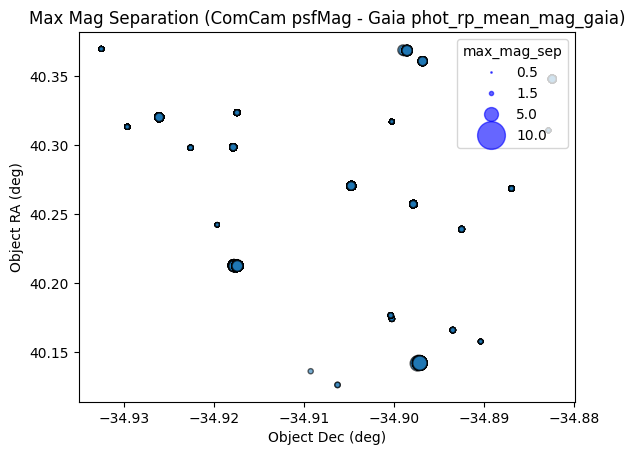

In [36]:
r_band.index.name = '_healpix_29'
df = r_band.join(result, on='_healpix_29')
def max_mag_sep(mag_sep):
    if mag_sep.shape[0] == 0:
        result = 0
    else:
        result = mag_sep.max()
    return {'max_mag_sep': result}
df = df.join(df.reduce(max_mag_sep, 'mag_sep'))
df['max_mag_sep']
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Scatter plot
plt.scatter(df['coord_dec_object_lc'], df['coord_ra_object_lc'], s=df['max_mag_sep'] * 20, alpha=0.6, edgecolors='black')

# Create a legend for the size of the points
sizes = [10, 30, 100, 200]  # Example sizes
labels = [f"{size / 20:.1f}" for size in sizes]  # Convert back to original scale
handles = [mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=size / 10, alpha=0.6) for size in sizes]
plt.legend(handles, labels, title="max_mag_sep", loc="upper right")

plt.xlabel('Object Dec (deg)')
plt.ylabel('Object RA (deg)')
plt.title('Max Mag Separation (ComCam psfMag - Gaia phot_rp_mean_mag_gaia)')
plt.show()

# Apply Forced Photometry
Measure standard deviation of the points using forced photometry and forced photomery on difference images. 

<class 'numpy.ndarray'> None
<class 'numpy.ndarray'> None
<class 'numpy.ndarray'> None
<class 'numpy.ndarray'> None


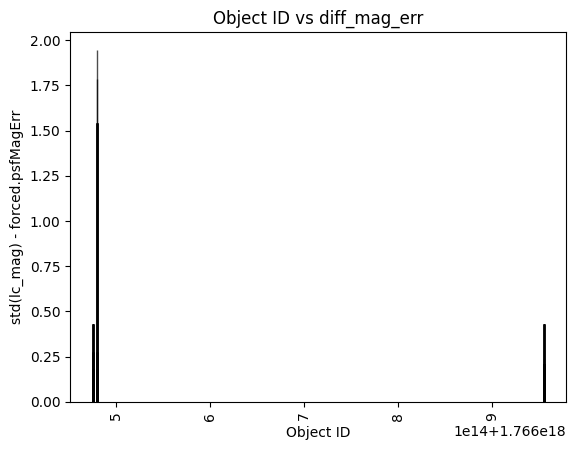

In [31]:
r_band.index.name = '_healpix_29'
df = r_band.join(result, on='_healpix_29')
def std_lc_mag(lc_mag, expected_err):
    try:
        result = lc_mag.std()
    except Exception as e:
        print(type(lc_mag), lc_mag)
        result = 0
    diff_mag_err = abs((expected_err - result).mean()) if result != 0 else 0
    return {'lc_mag_std': result, 'diff_mag_err': diff_mag_err}
df = df.join(df.reduce(std_lc_mag, 'lc_object_lc.psfMag', 'forcedSource_object_lc.psfMagErr'))

# Create a bar chart for objectId_object_lc vs diff_mage_err
plt.bar(df['objectId_object_lc'], df['diff_mag_err'], color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Object ID')
plt.ylabel('std(lc_mag) - forced.psfMagErr')
plt.title('Object ID vs diff_mag_err')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()